# Brand Analysis 


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import altair as alt
alt.data_transformers.disable_max_rows()

import sys
sys.path.append("../scripts/")

In [2]:
from access_data import authenticate_google_drive, grab_google_drive_folder_data

drive = authenticate_google_drive()

# Load in data with embeddings
# file_path = "multi-qa-mpnet_scores.csv"
# data_mpnet  = grab_google_drive_folder_data(drive=drive,credential_file="0_data_collection/credentials/google_drive_folder_id.json",filename = file_path)

# file_path = 'xgboost_bge_test_predictions.csv'
# data_bge  = grab_google_drive_folder_data(drive=drive,credential_file="0_data_collection/credentials/google_drive_folder_id.json",filename = file_path)

# file_path = 'open_ai_labeled_responses.csv'
# data_ai  = grab_google_drive_folder_data(drive=drive,credential_file="0_data_collection/credentials/google_drive_folder_id.json",filename = file_path)

file_path = 'analyze_data.csv'
df  = grab_google_drive_folder_data(drive=drive, filename = file_path)

Successfully loaded 'analyze_data.csv' into a DataFrame!


In [ ]:
# create negative flag
df['negativate_flag'] = np.where(df['open_ai_sentiment'] == 'Negative', 1, 0)

# Grouped by brand/search_query
data_brand_agg = df.groupby(by = 'search_query', as_index = False)\
                          .agg({'negativate_flag': 'mean'})

data_brand_agg.head()

In [ ]:
data_brand_agg = df.groupby(by = 'search_query', as_index = False)\
                          .agg({'negativate_flag': 'mean'})

data_brand_agg.head()

,search_query,negativate_flag
0,Redfin,0.335043
1,Rocket Mortgage,0.304895
2,Turbo Tax,0.347686
3,UWM,0.196078
4,Wells Fargo,0.394649


In [40]:
import base64
import altair as alt
import pandas as pd

from io import BytesIO
from PIL import Image

brands = ['Rocket Mortgage']
brand = brands[0]

image_paths = ["brand_images/redfin_logo.png",
               "brand_images/rkt_logo.png",
               "brand_images/tt_logo.png",
               "brand_images/uwm_logo.png",
               "brand_images/wf_logo.webp",
               "brand_images/xfinity_logo.png",
               "brand_images/zillow_logo.png"]
base64_images = []
for image_path in image_paths:
    pil_image = Image.open(image_path)
    output = BytesIO()
    pil_image.save(output, format='PNG')
    base64_images.append(
        "data:image/png;base64," + base64.b64encode(output.getvalue()).decode()
    )

data_brand_agg['image'] = base64_images
data_brand_agg['negativate_flag_nudged'] = data_brand_agg['negativate_flag'] + .032


In [41]:
brand_dict = {'Rocket Mortgage' : '#e74a51',
              'UWM': '#025f9f',
              'Redfin': '#c82020',
              'Zillow': '#0639d8',
              'Xfinity': '#5e34ef',
              'Turbo Tax': '#d02a1d',
              'Wells Fargo': '#f6c83f'}

In [42]:
data_brand_agg.head()

,search_query,negativate_flag,image,negativate_flag_nudged
0,Redfin,0.335043,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",0.373043
1,Rocket Mortgage,0.304895,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",0.342895
2,Turbo Tax,0.347686,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",0.385686
3,UWM,0.196078,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",0.234078
4,Wells Fargo,0.394649,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",0.432649


alt.LayerChart(...)
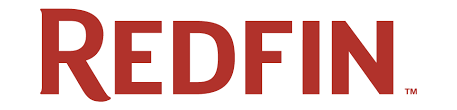
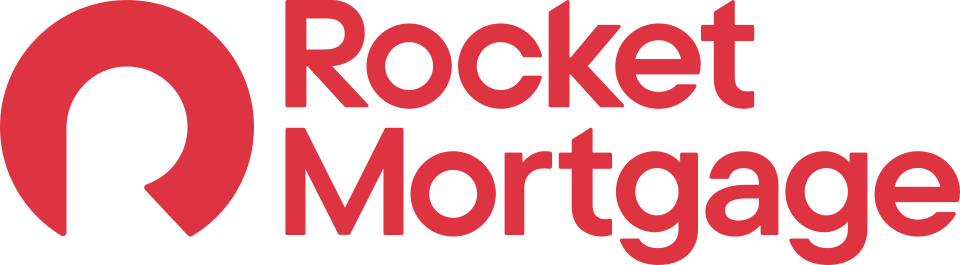
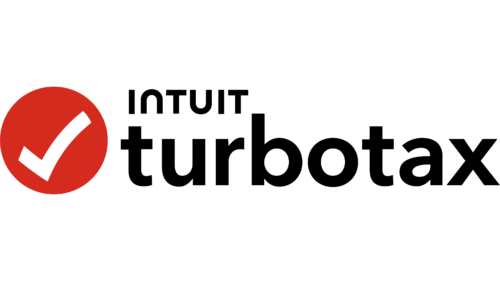
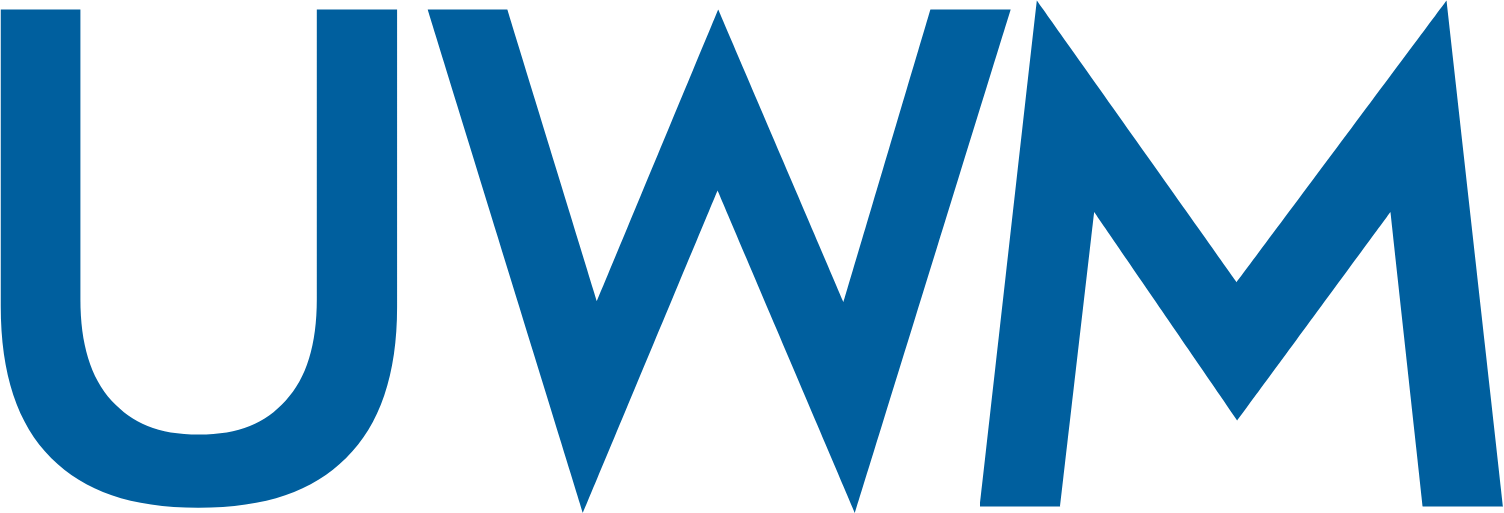
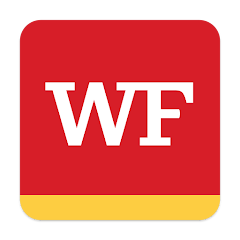
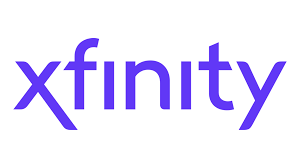
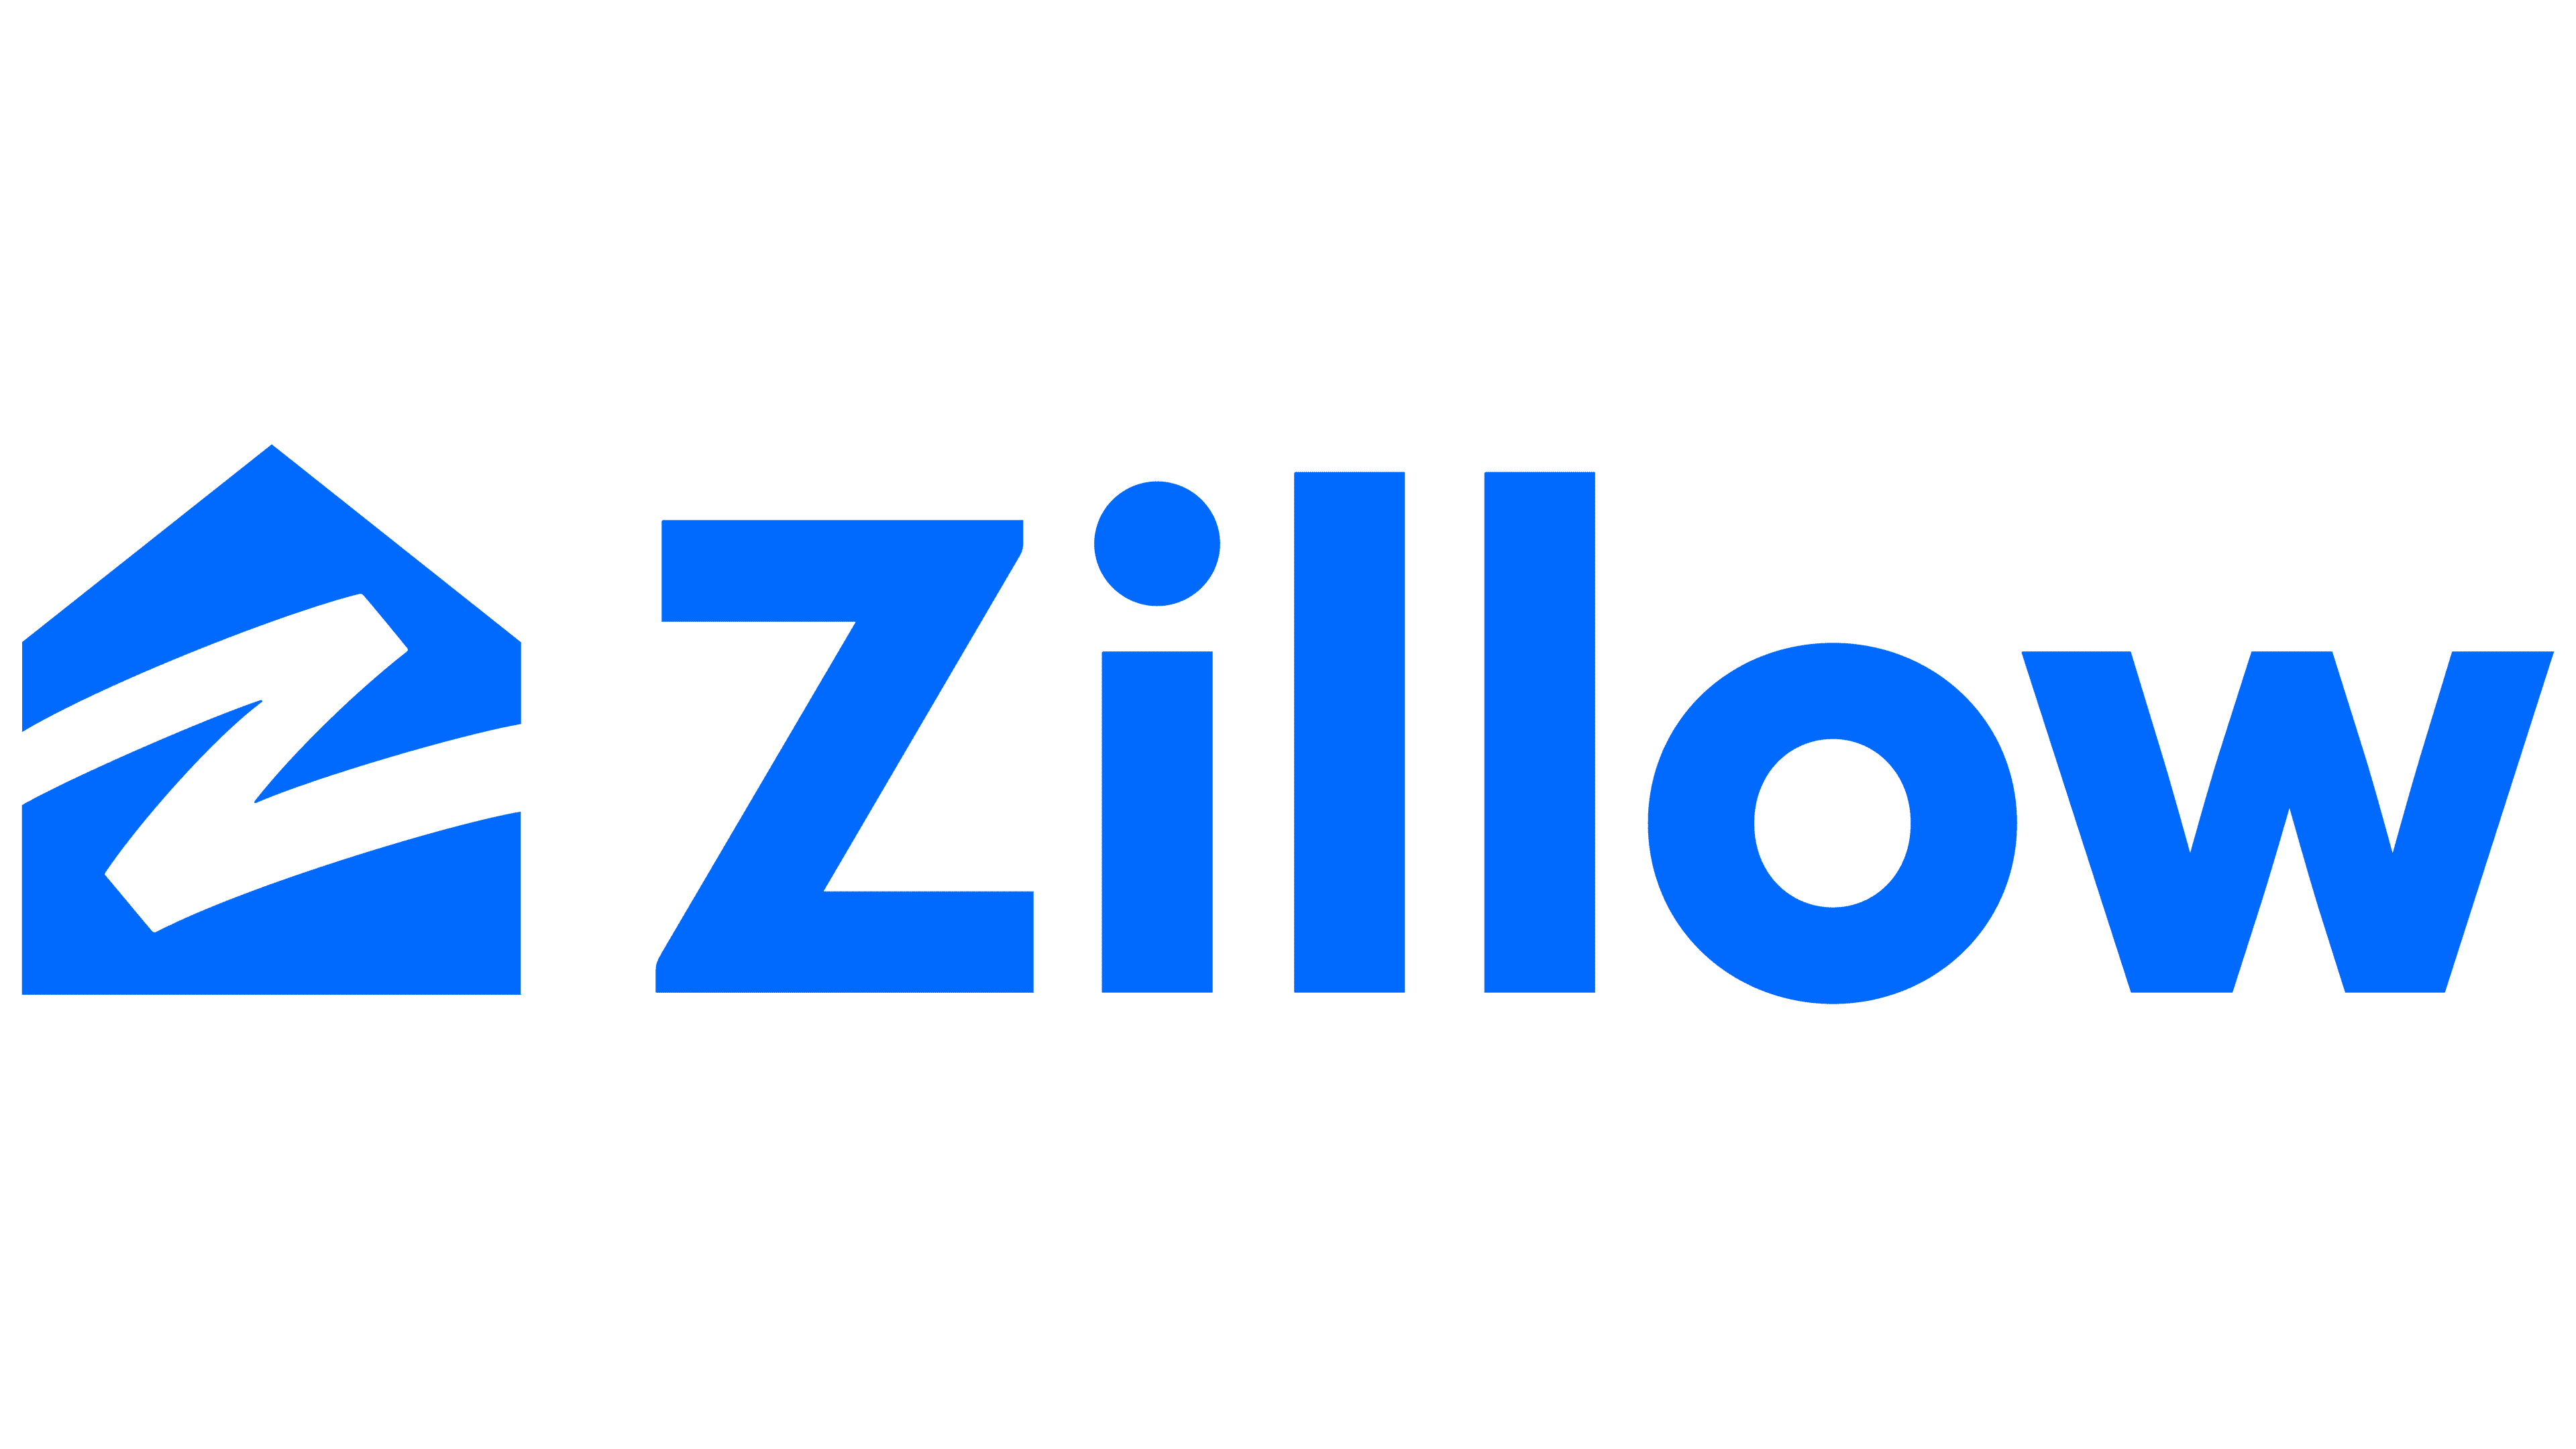

In [58]:
logo_chart = alt.Chart(data_brand_agg).mark_image(width = 80, height = 60).encode(
    x=alt.X('search_query', title='Brand', sort = '-y'),
    y=alt.Y('negativate_flag_nudged',  scale=alt.Scale(domain=[0, .5]),title=''),
    url = 'image'  # This is correct now
).properties(height = 400, width = 825, title = "Average Negative Propensity Score by Company")


brand_colors = brand_dict # Map brands to colors
color_scale = alt.Scale(domain=list(brand_colors.keys()), range=list(brand_colors.values())) 

bar_chart = alt.Chart(data_brand_agg).mark_bar(size = 50).encode(
    x=alt.X('search_query', title='Brand', sort = '-y', axis=alt.Axis(labels=False)),
    y=alt.Y('negativate_flag',  scale=alt.Scale(domain=[0, .62]),title='% of Posts Rated Negative'),
    color = alt.Color('search_query', scale=color_scale, legend=None) 
).properties(height = 400, width = 825, title = "% of Reddit Posts Rated as 'Negative' by the Open AI Model")

(bar_chart + logo_chart).configure_title(fontSize=28).configure_axis(
    labelFontSize=28,
    titleFontSize=28
).configure_axis(
    grid=False
).configure_view(
    stroke=None
)
